## Anomaly detection using [KDDCUP](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data Part 1

One of my recent interests that started during COVID-19 is network security. In general, the amount of [internet traffic](https://www.cisco.com/c/en/us/solutions/collateral/executive-perspectives/annual-internet-report/white-paper-c11-741490.html) has steadily increased and will do so as technology evolves, but along with it security needs to improve and increase as well. This notebook series is built to help understand what network data might look like and how it can be used to detect anomalies within a network. 

The [dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) used was for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. 


#### Load the data

In [132]:
import gzip
import os
import pandas as pd

df = pd.read_csv(os.getcwd()+'/kddcup.data_10_percent.gz', compression='gzip', header=None)
df.columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [133]:
df.shape

(494021, 42)

The 10% data has a 494K rows and 42 columns. There are 23 unique valeus for the label column where one of them is normal, making 22 of those a 'bad' outcome. We'll look at the distribution to see if the data is balanced. 

<AxesSubplot:>

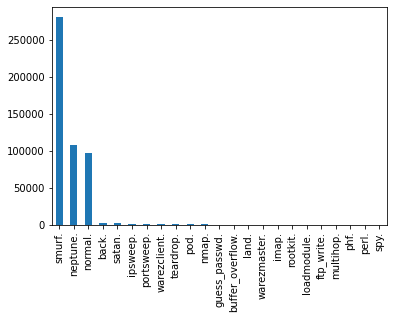

In [134]:
df.label.value_counts().plot(kind='bar')

Out of the 23 categories including normal activity, we can see that 'smurf' & 'neptune' are the highest intrusion categories followed by the normal state. We'll look at the values in percent to get a better idea. 

In [135]:
label_count = pd.DataFrame(df.groupby(['label'])['label'].count())
label_count.columns = ['Count']
label_count['Percent'] = round(label_count.Count*100 / label_count.Count.sum(),2)
label_count.sort_values('Count', ascending=False)

,Count,Percent
label,,
smurf.,280790,56.84
neptune.,107201,21.70
normal.,97278,19.69
back.,2203,0.45
satan.,1589,0.32
ipsweep.,1247,0.25
portsweep.,1040,0.21
warezclient.,1020,0.21
teardrop.,979,0.20


## Data Pre-processing

#### One hot encoding
Since there are object columns the data needs to go through the one hot encoding process first. In the first iteration we'll group the labels as 'Good(0)' and 'Bad(1)' first in the process.

In [136]:
df = pd.get_dummies(data=df, columns=df.loc[:, df.dtypes == object].columns.drop('label'))
df.label = df.label.replace(to_replace=df.label.unique(), value=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
df.shape

(494021, 119)

#### Dropping columns with low variance

Next we'll drop columns with variance less than 0.3. There are many ways such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), or [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), just to name a few when it comes to this process, but here we will keep it simple. 

In [141]:
df = df.loc[:, df.std() > .3]
df.shape

(494021, 26)

We go from 119 columns to 26 columns. At this point let's take a look at the univariate distribution. For an overview of the data.

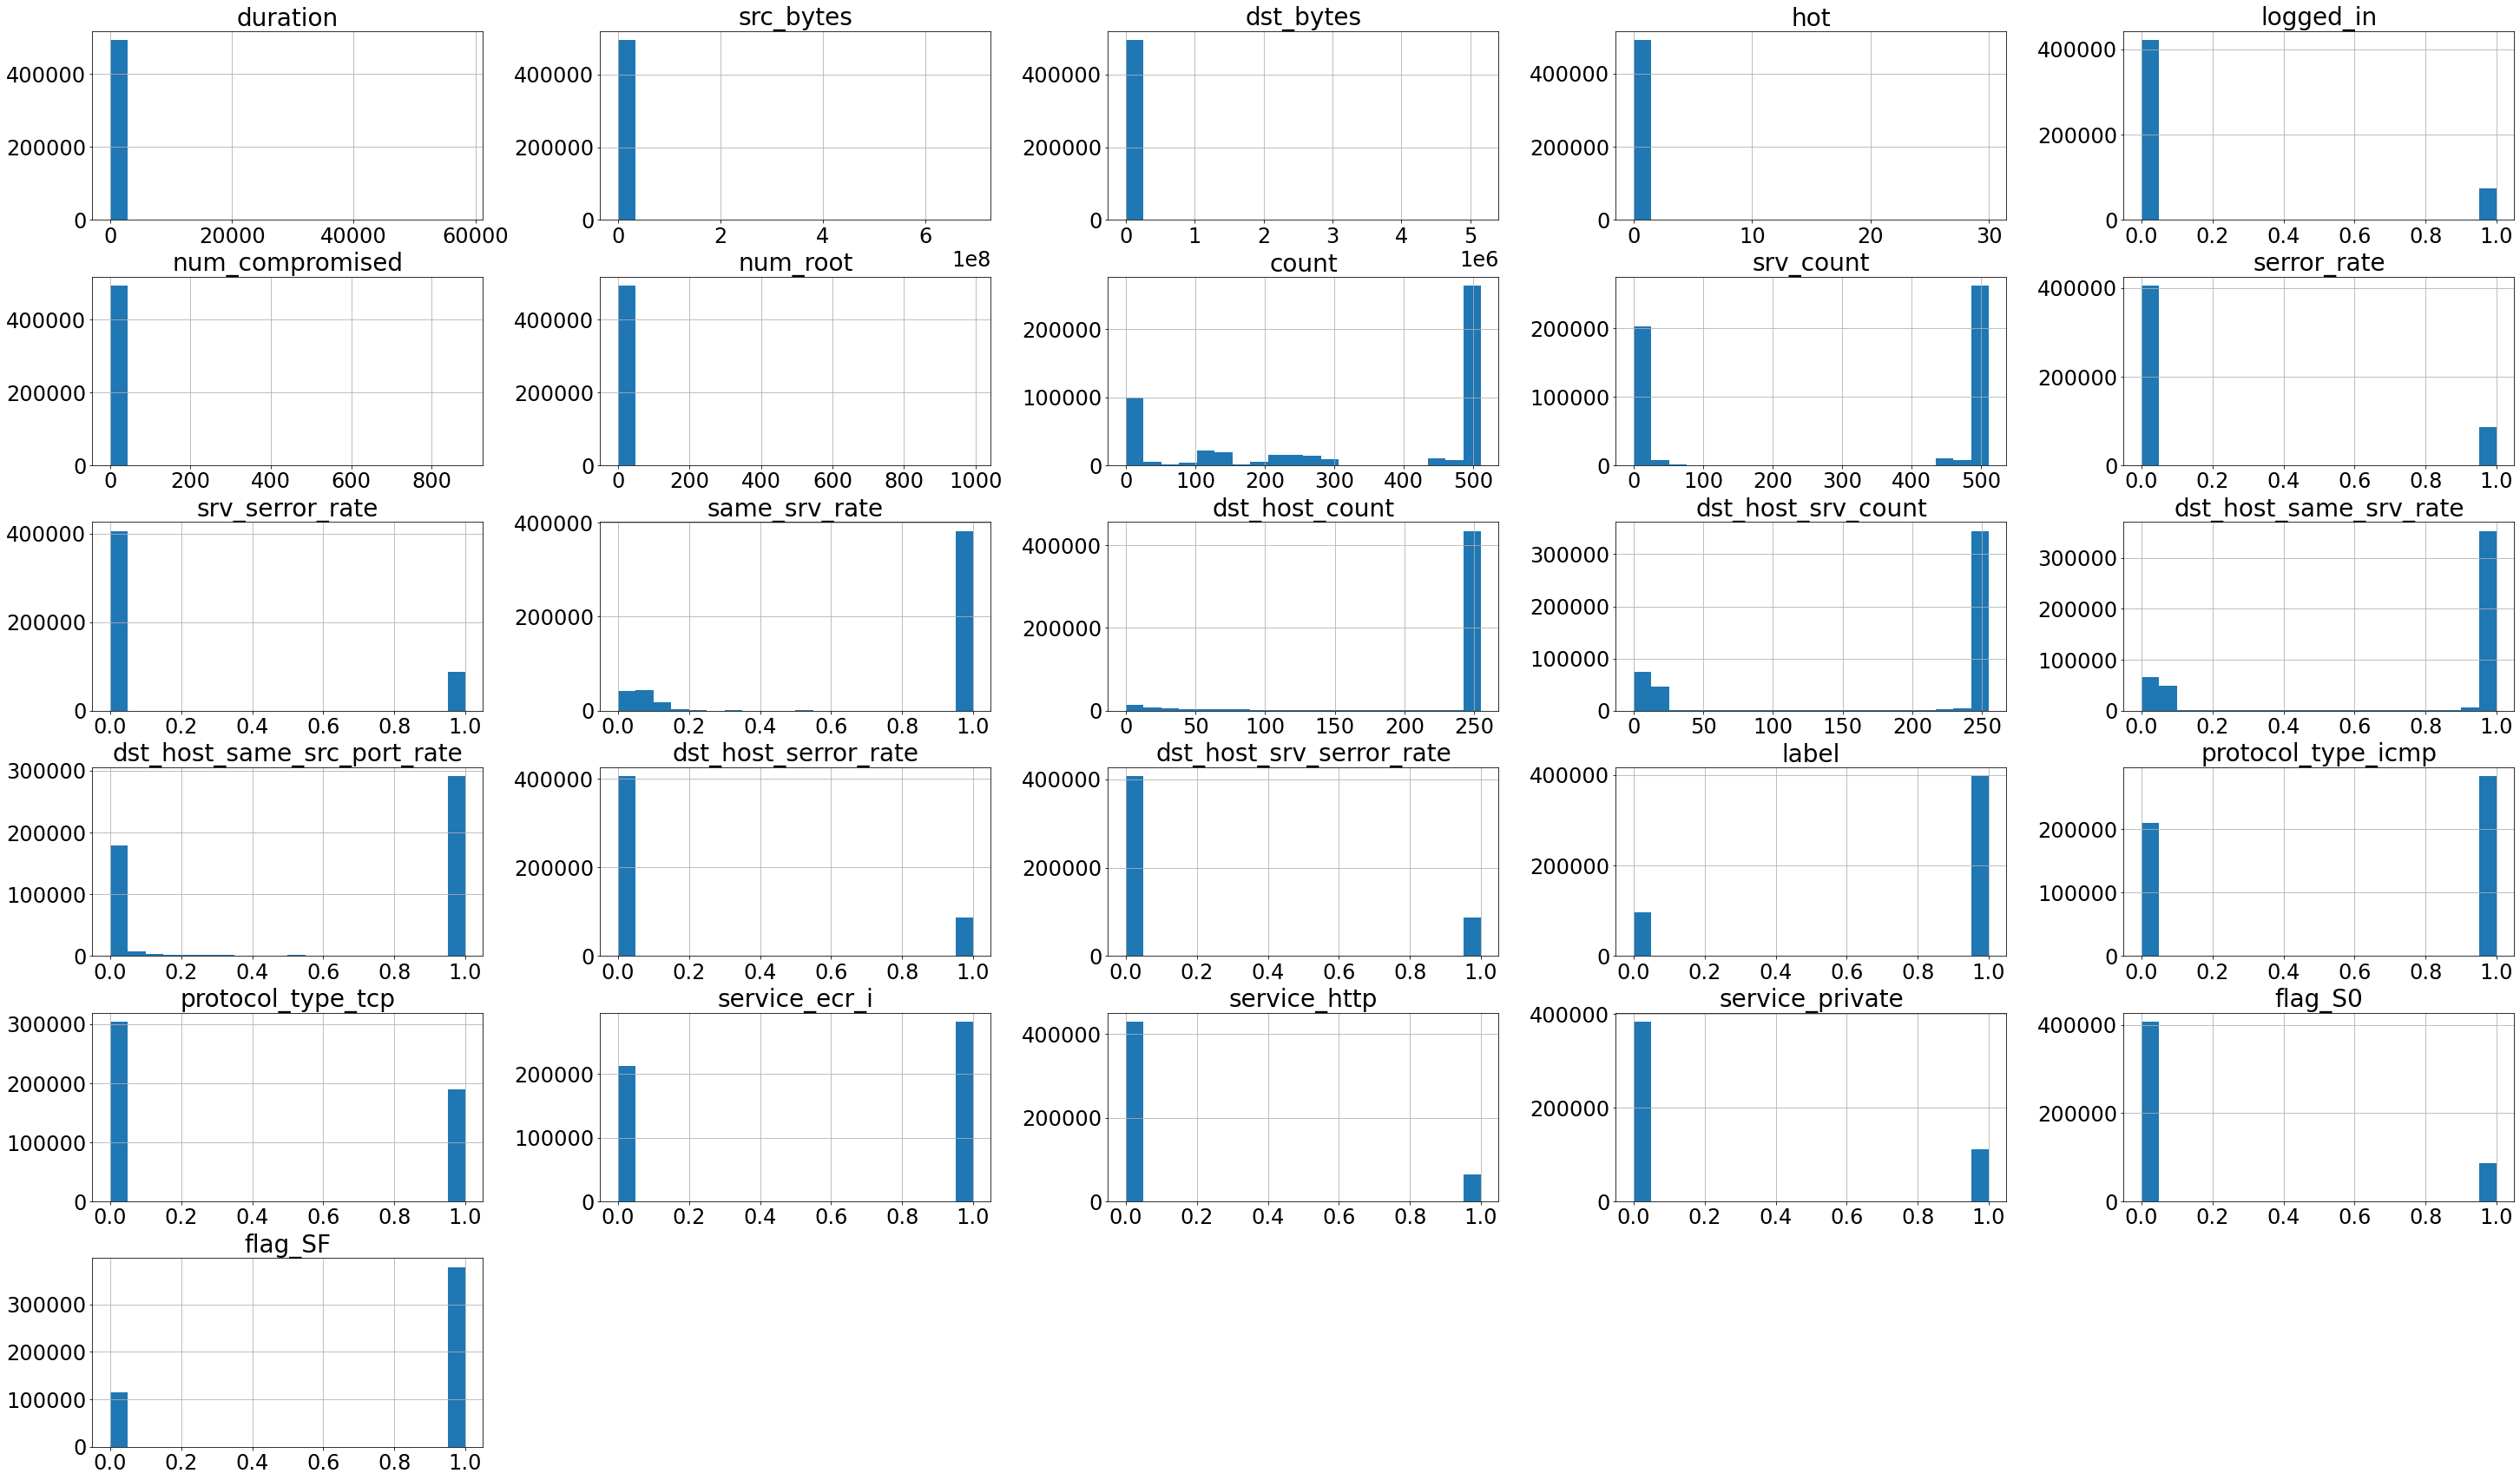

In [142]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'28',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)
df.hist(figsize=(50, 30), bins=20)
plt.show()

## Building a benchmark model
We build a benchmark model using [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to see how the performance is before looking into ways to improve the model.

#### Split the data

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df.label, test_size=0.30, 
                                                    random_state=101,
                                                    stratify=df.label)

#### Logistic Regression

In [165]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print("Accuracy = "+ str(round(roc_auc_score(y_test, predictions),4)))

Accuracy = 0.9868


Surprisingly, the logistic regression model seems to perform fairly well at 98.5% accuracy. Note that as the first iteration this model would only be able to tell if there is an intrusion or not rather than the type of the intrusion occurring, which can be critical information when it comes to repsonding to a threat. 

#### Randomforest

We'll build another model to see if there is any improvement, we will include a step that will allow us to narrow down the parameters using a method called [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). This method tests different parameters as input and selects the best combination based on the scoring method selected. 

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Reduce parameter lengths for shorter run time. 
#The following grid runs around 3~4 hrs on a almost 8 year old macbook.
param_grid = {
    'n_estimators': [500,800,1000],
    'max_depth': [25,50,100,200],
    'min_samples_leaf': [5000,8000,10000],
    'max_features': ['log2','sqrt']
    }

#### Run the model

In [152]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, 
                           return_train_score=True,verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time=  52.1s
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time= 1.0min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time= 1.1min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time= 1.6min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time= 1.9min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time= 2.0min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=1000; total time= 2.1min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=1000; total time= 1.2min
[CV] END max_depth=25, max_features=log2, min_samples_leaf=5000, n_estimators=1000; total time= 1.3min
[CV] END max_dept

[CV] END max_depth=50, max_features=log2, min_samples_leaf=10000, n_estimators=1000; total time= 1.2min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=500; total time=  39.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=500; total time=  38.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=500; total time=  37.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=800; total time= 1.0min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=800; total time= 1.1min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=800; total time= 1.1min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=1000; total time= 1.2min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=1000; total time= 1.3min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5000, n_estimators=

[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=10000, n_estimators=1000; total time= 1.1min
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=10000, n_estimators=1000; total time= 1.1min
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time=  33.7s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time=  34.0s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=500; total time=  32.8s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time=  53.5s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time=  54.0s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=800; total time=  52.9s
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_estimators=1000; total time= 1.1min
[CV] END max_depth=200, max_features=log2, min_samples_leaf=5000, n_

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [25, 50, 100, 200],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [5000, 8000, 10000],
                         'n_estimators': [500, 800, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=2)

#### Get ROC/AUC Score

In [168]:
from sklearn.metrics import roc_auc_score
round(roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1]),8)

0.99999869

Based on the results the random forest has a better performance based on ROC/AUC score by 1.3%. It is possible that the results are better due to the fact that we have forced the labels to be binary rather than a multi-class classification.

In [172]:
roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1]) - roc_auc_score(y_test, predictions)

0.013159435084168947